In [41]:
%load_ext autoreload
%autoreload 2

import os, codecs, string, random
import numpy as np
import pandas as pd

#NLP libraries
import spacy, nltk, gensim, sklearn
import pyLDAvis.gensim_models

import matplotlib.pyplot as plt


#The data
advBeer_root = 'DATA/BeerAdvocate/'
df_adv_breweries = pd.read_csv(advBeer_root + 'breweries.csv')
df_adv_users = pd.read_csv(advBeer_root + 'users.csv')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

In [3]:
#from functions import read_data
#mysmallratings=read_data.fetch_reviews(advBeer_root +'BeerAdvocate.tar.gz', max_csv_size = 500000,early_stop = 0)

In [4]:
df_adv_breweries.head()

,id,location,name,nbr_beers
0,39912,Kyrgyzstan,Abdysh-Ata (Абдыш Ата),5
1,39913,Kyrgyzstan,Arpa (АРПА),1
2,39914,Kyrgyzstan,Bear Beer,4
3,39915,Kyrgyzstan,Blonder Pub,4
4,39916,Kyrgyzstan,Kellers Bier,2


In [5]:
nlp = spacy.load('en_core_web_sm')

In [6]:
#books = list()

#for book_file in os.listdir(advBeer_root):
#    if ".txt" in book_file:
#        if not ".gz" in book_file:
#            print(book_file)
#            with codecs.open(os.path.join(corpus_advBeer_root,book_file), encoding="utf8") as f:
#                books.append(f.read())

In [7]:
beers_name = ""
beer_id = ""
brewery_name = ""
brewery_id = ""
user_id = ""
text = []
data = []
with open(advBeer_root + "reviews.txt", encoding='utf-8') as f:
    nb_review = 0
    
    for line in f.readlines():
        line = line[:-1]
        #print(line)

        if line.startswith("beer_id: "):
            beer_id = line[9:]
            #print('BEER ID:', beers_id)
            continue

        if line.startswith("brewery_id: "):
            brewery_id = line[11:]
            #location_id = df_adv_breweries.loc[df_adv_breweries['id'] == int(brewery_id), 'location']
            #print('Brewery ID:', brewery_id)
            continue

        if line.startswith("text: "):
            review = line[6:]
            #print('TEXT:', reviews)
            data.append([beer_id,brewery_id, review])
            #if (nb_review % 1000 == 0):
                #print(nb_review)
            #nb_review += 1
            continue
            
            
df_rev = pd.DataFrame(data, columns=["beer_id","brewery_id", "review"])
       

In [8]:
df_rev.shape

(2589586, 3)

In [9]:
df_rev_low = df_rev.loc[:100000, :]

In [12]:
df_rev_low.shape

(100001, 3)

In [11]:
# check all brewery id are in the dataset brewery
print(df_rev_low['brewery_id'].astype(int).isin(df_adv_breweries['id']).sum(), df_rev.shape[0])

df_rev_low.head()

100001 2589586


,beer_id,brewery_id,review
0,142544,37262,"From a bottle, pours a piss yellow color with ..."
1,19590,10093,Pours pale copper with a thin head that quickl...
2,19590,10093,"500ml Bottle bought from The Vintage, Antrim....."
3,19590,10093,Serving: 500ml brown bottlePour: Good head wit...
4,19590,10093,"500ml bottlePours with a light, slightly hazy ..."


In [23]:
review = df_adv_breweries.loc[df_adv_breweries['id'].isin(df_rev_low['brewery_id'].astype(int)),['id','location']]
print(review.shape)

(1024, 2)


In [42]:
review.head()

,id,location
8,37262,Gabon
9,10093,Northern Ireland
11,297,Northern Ireland
12,40360,Northern Ireland
13,3415,Northern Ireland


In [43]:
df_rev_low.head()

,beer_id,brewery_id,review,location
0,142544,37262,"From a bottle, pours a piss yellow color with ...",Gabon
1,19590,10093,Pours pale copper with a thin head that quickl...,Northern Ireland
2,19590,10093,"500ml Bottle bought from The Vintage, Antrim.....",Northern Ireland
3,19590,10093,Serving: 500ml brown bottlePour: Good head wit...,Northern Ireland
4,19590,10093,"500ml bottlePours with a light, slightly hazy ...",Northern Ireland


In [20]:
counter = 0

def my_location4(x, review):
    
    #print(x, type(x))
    
    location =  review.loc[review['id'] == int(x),'location'].values  
    
    return location[0]
    

In [25]:
df_rev_low.loc[:,'location'] = df_rev_low['brewery_id'].apply(my_location4, args= (review,) )

C:\Users\xavie\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [27]:
df_rev_low.head()

,beer_id,brewery_id,review,location
0,142544,37262,"From a bottle, pours a piss yellow color with ...",Gabon
1,19590,10093,Pours pale copper with a thin head that quickl...,Northern Ireland
2,19590,10093,"500ml Bottle bought from The Vintage, Antrim.....",Northern Ireland
3,19590,10093,Serving: 500ml brown bottlePour: Good head wit...,Northern Ireland
4,19590,10093,"500ml bottlePours with a light, slightly hazy ...",Northern Ireland


### Sentiment Analyzer

In [13]:
# try a simple example to check the code is okay
example = df_rev_low.review[0]
vs = analyzer.polarity_scores(example)

In [14]:
print(example, '\n')
print('Negative sentiment:',vs['neg'])
print('Neutral sentiment:',vs['neu'])
print('Positive sentiment:',vs['pos'])
print('Compound sentiment:',vs['compound'])

From a bottle, pours a piss yellow color with a fizzy white head.  This is carbonated similar to soda.The nose is basic.. malt, corn, a little floral, some earthy straw.  The flavor is boring, not offensive, just boring.  Tastes a little like corn and grain.  Hard to write a review on something so simple.Its ok, could be way worse. 

Negative sentiment: 0.139
Neutral sentiment: 0.763
Positive sentiment: 0.098
Compound sentiment: -0.4312


In [17]:
import matplotlib.pyplot as plt
ROW = 10000
df_rev_low.shape

(100001, 3)

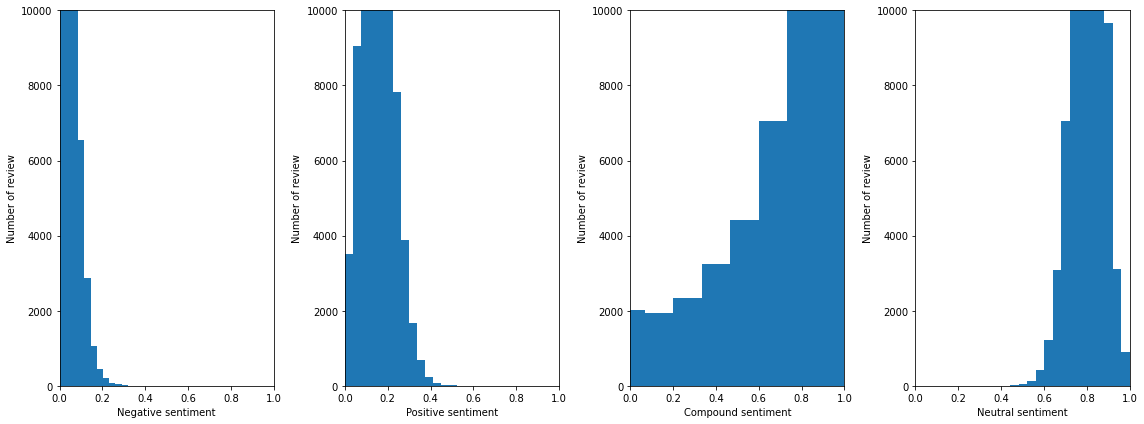

In [16]:
plt.close('all')
fig = plt.figure(figsize=(16,6))

ax1 = plt.subplot(141)
ax2 = plt.subplot(142)
ax3 = plt.subplot(143)
ax4 = plt.subplot(144)

negative_sent = []
[negative_sent.append(analyzer.polarity_scores(sent)['neg']) for sent in df_rev_low.review]
ax1.hist(negative_sent,bins=15)
ax1.set(xlim = [0,1], ylim = [0,ROW] , xlabel='Negative sentiment', ylabel = 'Number of review') 

positive_sent = []
[positive_sent.append(analyzer.polarity_scores(sent)['pos']) for sent in df_rev_low.review]
ax2.hist(positive_sent,bins=15)
ax2.set(xlim = [0,1], ylim = [0,ROW] , xlabel='Positive sentiment', ylabel = 'Number of review') 

total_sent = []
[total_sent.append(analyzer.polarity_scores(sent)['compound']) for sent in df_rev_low.review]
ax3.hist(total_sent,bins=15)
ax3.set(xlim = [0,1], ylim = [0,ROW] , xlabel='Compound sentiment', ylabel = 'Number of review') 

neutre_sent = []
[neutre_sent.append(analyzer.polarity_scores(sent)['neu']) for sent in df_rev_low.review]
ax4.hist(neutre_sent,bins=15)
ax4.set(xlim = [0,1], ylim = [0,ROW] , xlabel='Neutral sentiment', ylabel = 'Number of review') 

plt.tight_layout()

In [ ]:
#print('Number of positive sentences:',sum(np.array(sents)>=0.05))
#print('Number of negative sentences:',sum(np.array(sents)<=-0.05))
#print('Number of neutral sentences:',sum(np.abs(np.array(sents))<0.05))

###  Sentiments Analysis with Location

In [28]:
df_rev_low['location'].value_counts()

England             69395
Scotland            24089
Mexico               2042
China                1402
Wales                 969
Singapore             538
South Korea           464
Romania               445
Northern Ireland      404
Montenegro             67
Saint Lucia            54
Nigeria                46
Hong Kong              43
Georgia                37
Zambia                  3
Burkina Faso            1
Benin                   1
Gabon                   1
Name: location, dtype: int64

In [37]:
country_groups = df_rev_low.groupby(by="location")

In [38]:
country_groups.head(n=10)

,beer_id,brewery_id,review,location
0,142544,37262,"From a bottle, pours a piss yellow color with ...",Gabon
1,19590,10093,Pours pale copper with a thin head that quickl...,Northern Ireland
2,19590,10093,"500ml Bottle bought from The Vintage, Antrim.....",Northern Ireland
3,19590,10093,Serving: 500ml brown bottlePour: Good head wit...,Northern Ireland
4,19590,10093,"500ml bottlePours with a light, slightly hazy ...",Northern Ireland
...,...,...,...,...
97964,74380,26974,"A: reddish copper in color, the body looks com...",Mexico
97965,98130,26974,A. La Chingoneria Chekate Esta pours a fairly ...,Mexico
97966,283202,26974,Copper color with a thin head that vanishes fa...,Mexico
97967,77800,26974,Pours a black color. 1/4 inch head of an off-...,Mexico


In [46]:
for country, group in country_groups:
    print('country',country)
    print('-')
    print('groupe info', group.columns)
    print('group', group['review'])
    print('-----------------')

country Benin
-
groupe info Index(['beer_id', 'brewery_id', 'review', 'location'], dtype='object')
group 97958    Beer bottle (30 cl.), purchased in Bénin (by a...
Name: review, dtype: object
-----------------
country Burkina Faso
-
groupe info Index(['beer_id', 'brewery_id', 'review', 'location'], dtype='object')
group 96852    Shared by the one and only Travlr. Thanks Gene...
Name: review, dtype: object
-----------------
country China
-
groupe info Index(['beer_id', 'brewery_id', 'review', 'location'], dtype='object')
group 95396    Bottle poured into pilsner glassTwo finger tau...
95397    paulaner brauhaus (pulana pijiu fang) beijing,...
95398    Appearance: Pale golden color. Insane amount o...
95399    Poured into a large weizen glass from the tap ...
95400    On draft as part of a sampler tray. Appearance...
                               ...                        
96793    For any of you that read this, I've used some ...
96794    A Truly wonderful beer by Chinese standards. T

In [52]:
import numpy as np
data = []



for country, group in country_groups:
    negative_sent = []
    positive_sent = []
    neutre_sent=[]
    [negative_sent.append(analyzer.polarity_scores(sent)['neg']) for sent in group.review]
    [positive_sent.append(analyzer.polarity_scores(sent)['pos']) for sent in group.review]
    [neutre_sent.append(analyzer.polarity_scores(sent)['neu']) for sent in group.review]

    data.append([country,np.array(negative_sent).mean(),np.array(positive_sent).mean(), 
                 np.array(neutre_sent).mean(), group.shape[0]])
    print('country:', country, data[-1])
    

   

resultats = pd.DataFrame(data, columns=["country","neg sentiment", "pos sentiment", "neu sentiment", "nb of review"])


country: Benin ['Benin', 0.051, 0.064, 0.884, 1]
country: Burkina Faso ['Burkina Faso', 0.066, 0.104, 0.83, 1]
country: China ['China', 0.052725392296718965, 0.12922111269614836, 0.8180427960057063, 1402]
country: England ['England', 0.042838907702284025, 0.15389888320484188, 0.8032617479645507, 69395]
country: Gabon ['Gabon', 0.139, 0.098, 0.763, 1]
country: Georgia ['Georgia', 0.03759459459459459, 0.12278378378378381, 0.8395405405405405, 37]
country: Hong Kong ['Hong Kong', 0.04909302325581396, 0.15667441860465114, 0.7941395348837208, 43]
country: Mexico ['Mexico', 0.0454588638589618, 0.14143584720861901, 0.8131185112634671, 2042]
country: Montenegro ['Montenegro', 0.05529850746268656, 0.1314776119402985, 0.8132238805970149, 67]
country: Nigeria ['Nigeria', 0.058108695652173914, 0.13406521739130436, 0.8078260869565218, 46]
country: Northern Ireland ['Northern Ireland', 0.04454207920792078, 0.13768811881188117, 0.8177920792079209, 404]
country: Romania ['Romania', 0.06217528089887641,

In [56]:
pd.set_option('max_colwidth', 1000)
resultats

,country,neg sentiment,pos sentiment,neu sentiment,nb of review
0,Benin,0.051000,0.064000,0.884000,1
1,Burkina Faso,0.066000,0.104000,0.830000,1
2,China,0.052725,0.129221,0.818043,1402
3,England,0.042839,0.153899,0.803262,69395
4,Gabon,0.139000,0.098000,0.763000,1
5,Georgia,0.037595,0.122784,0.839541,37
6,Hong Kong,0.049093,0.156674,0.794140,43
7,Mexico,0.045459,0.141436,0.813119,2042
8,Montenegro,0.055299,0.131478,0.813224,67
9,Nigeria,0.058109,0.134065,0.807826,46


In [95]:
df_rev_low_sco = df_rev_low.loc[df_rev_low['location'] == 'Scotland',:]
df_rev_low_wal = df_rev_low.loc[df_rev_low['location'] == 'Wales',:]
df_rev_low_noir = df_rev_low.loc[df_rev_low['location'] == 'Northern Ireland',:]

[(0.0, 1.0),
 (0.0, 10000.0),
 Text(0.5, 0, 'Negative sentiment Northern Ireland'),
 Text(0, 0.5, 'Number of review gabon')]

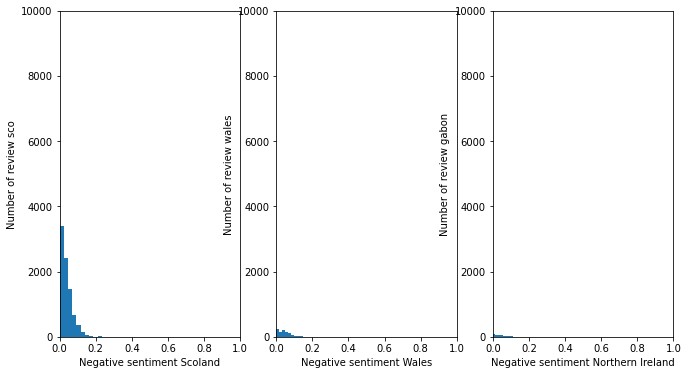

In [99]:
plt.close('all')
fig = plt.figure(figsize=(11,6))

ax1 = plt.subplot(131)
ax2 = plt.subplot(132)
ax3 = plt.subplot(133)

negative_sent = []
[negative_sent.append(analyzer.polarity_scores(sent)['neg']) for sent in df_rev_low_sco.review]
ax1.hist(negative_sent,bins=15)
ax1.set(xlim = [0,1], ylim = [0,ROW] , xlabel='Negative sentiment Scoland', ylabel = 'Number of review sco') 

negative_sent = []
[negative_sent.append(analyzer.polarity_scores(sent)['neg']) for sent in df_rev_low_wal.review]
ax2.hist(negative_sent,bins=15)
ax2.set(xlim = [0,1], ylim = [0,ROW] , xlabel='Negative sentiment Wales', ylabel = 'Number of review wales') 

negative_sent = []
[negative_sent.append(analyzer.polarity_scores(sent)['neg']) for sent in df_rev_low_noir.review]
ax3.hist(negative_sent,bins=15)
ax3.set(xlim = [0,1], ylim = [0,ROW] , xlabel='Negative sentiment Northern Ireland', ylabel = 'Number of review gabon') 




[(0.0, 1.0),
 (0.0, 10000.0),
 Text(0.5, 0, 'Positive sentiment Northern Ireland'),
 Text(0, 0.5, 'Number of review Northern Ireland')]

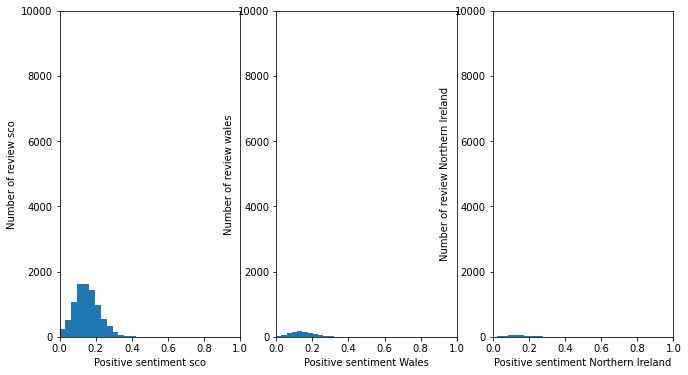

In [101]:
plt.close('all')
fig2 = plt.figure(figsize=(11,6))

ax1 = plt.subplot(131)
ax2 = plt.subplot(132)
ax3 = plt.subplot(133)

positive_sent = []
[positive_sent.append(analyzer.polarity_scores(sent)['pos']) for sent in df_rev_low_sco.review]
ax1.hist(positive_sent,bins=15)
ax1.set(xlim = [0,1], ylim = [0,ROW] , xlabel='Positive sentiment sco', ylabel = 'Number of review sco') 

positive_sent=[]
[positive_sent.append(analyzer.polarity_scores(sent)['pos']) for sent in df_rev_low_wal.review]
ax2.hist(positive_sent,bins=15)
ax2.set(xlim = [0,1], ylim = [0,ROW] , xlabel='Positive sentiment Wales', ylabel = 'Number of review wales') 

positive_sent=[]
[positive_sent.append(analyzer.polarity_scores(sent)['pos']) for sent in df_rev_low_noir.review]
ax3.hist(positive_sent,bins=15)
ax3.set(xlim = [0,1], ylim = [0,ROW] , xlabel='Positive sentiment Northern Ireland', ylabel = 'Number of review Northern Ireland') 

[(0.0, 1.0),
 (0.0, 10000.0),
 Text(0.5, 0, 'Neutral sentiment Northern Ireland'),
 Text(0, 0.5, 'Number of review Northern Ireland')]

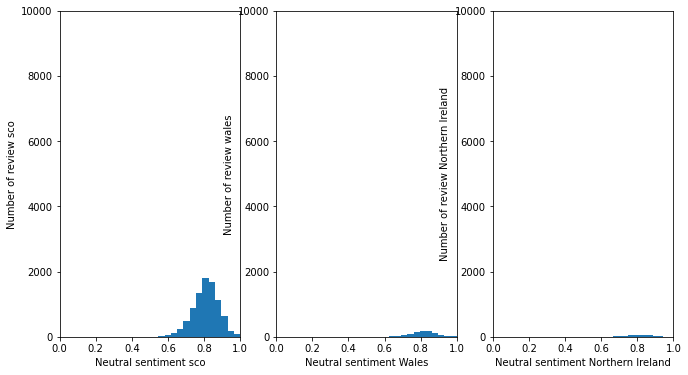

In [105]:
plt.close('all')
fig2 = plt.figure(figsize=(11,6))

ax1 = plt.subplot(131)
ax2 = plt.subplot(132)
ax3 = plt.subplot(133)

neutre_sent = []
[neutre_sent.append(analyzer.polarity_scores(sent)['neu']) for sent in df_rev_low_sco.review]
ax1.hist(neutre_sent,bins=15)
ax1.set(xlim = [0,1], ylim = [0,ROW] , xlabel='Neutral sentiment sco', ylabel = 'Number of review sco') 

neutre_sent=[]
[neutre_sent.append(analyzer.polarity_scores(sent)['neu']) for sent in df_rev_low_wal.review]
ax2.hist(neutre_sent,bins=15)
ax2.set(xlim = [0,1], ylim = [0,ROW] , xlabel='Neutral sentiment Wales', ylabel = 'Number of review wales') 

neutre_sent=[]
[neutre_sent.append(analyzer.polarity_scores(sent)['neu']) for sent in df_rev_low_noir.review]
ax3.hist(neutre_sent,bins=15)
ax3.set(xlim = [0,1], ylim = [0,ROW] , xlabel='Neutral sentiment Northern Ireland', ylabel = 'Number of review Northern Ireland') 